# Exercises for Introduction to Quantum Computing

Name: Pugazharasu Anancia Devaneyan (s6puanan) <br />
Matriculation number: 3300280

In [5]:
#Importing the required libraries
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *

# 1 Grover’s algorithm

a)

b) We know from the way the Grover's agorithm is designed, the probability of finding the item after $t$ iterations is given by,
$$P(\text { success })=\left|\left\langle x^* \mid \psi\right\rangle\right|^2=\sin ^2\left(\frac{2 t+1}{\sqrt{N}}\right)$$
We are to compute the largest value of $N=2^n$ such that $P(\text { success })=1$ for a single iteration i.e. $t=1$, thus we are to solve
$$P(\text { success })=\left|\left\langle x^* \mid \psi\right\rangle\right|^2=\sin ^2\left(\frac{3}{\sqrt{N}}\right) = 1$$
for $N$. Solving this, we find,
$$N = 4$$
This is exemplified by the following plot for $N$ vs $k$ where $k$ signifies the multivalued nature of the sine function.

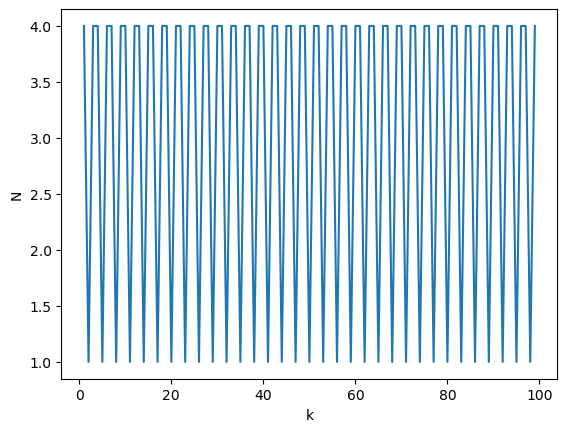

In [7]:
n = np.arange(1,100, dtype = int)
plt.xlabel("k")
plt.ylabel("N")
plt.plot(n,[1/((np.sin((np.pi * (i-0.5) )/3))**2) for i in n])

# 2 Error mitigation

a) The Hamiltonian,
$$H=X_0 \otimes Y_1$$
when exponentiated, takes the form,
$$U = e^{-i H \delta t} = ( \mathbb{I}_{n} \otimes \mathbb{I}_{n}) \cdot \cos (\delta t) - i \sin (\delta t) \cdot ( X_{0} \otimes Y_{1})$$
Computing the expectation value 
$$\left\langle\psi\left|Z_0 \otimes Z_1\right| \psi\right\rangle$$
for $\delta t = 1$ and
$$|\psi\rangle=e^{-i H \delta t}|00\rangle$$
, we have,
$$\left\langle\psi\left|Z_0 \otimes Z_1\right| \psi\right\rangle = 1$$

b) Running the code in the given Juypter notebook, we find that probabilistic error cancellation gives the best result (see below for details).

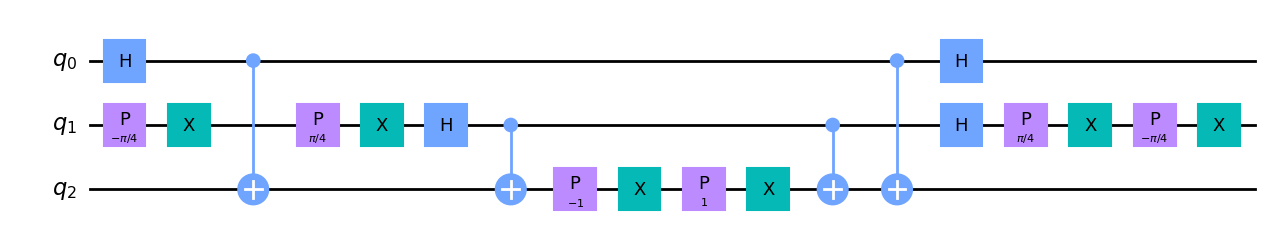

level 0:  EstimatorResult(values=array([0.822]), metadata=[{'variance': 0.32431600000000005, 'shots': 1000}])
level 1:  EstimatorResult(values=array([0.8407225]), metadata=[{'variance': 1.5997098182629468, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])
level 2:  EstimatorResult(values=array([0.60933333]), metadata=[{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.52, 0.788, 0.52], 'variance': [0.7296, 0.37905599999999995, 0.7296], 'shots': [1000, 1000, 1000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}])
level 3:  EstimatorResult(values=array([0.99423044]), metadata=[{'standard_error': 0.007806756644913258, 'confidence_interval': [0.9083033453137671, 1.0801575320869066], 'confidence_level': 0.95, 'shots': 157184, 'samples': 1228, 'sampling_overhe

In [6]:

# e^i theta Z
def Rz(qc, theta,i):
    qc.p(theta,i)
    qc.x(i)
    qc.p(-theta,i)
    qc.x(i)
    return qc


def expiHdt(circuit,dt, r):
    qc=QuantumCircuit(3)
    qc.h(0)
    qc.cx(0,2)
    qc = Rz(qc, -np.pi/4,1)
    qc.h(1)
    qc.cx(1,2)
    ##
    qc = Rz(qc, -dt,2)
    # ##
    qc.cx(1,2)
    qc.h(1)
    qc = Rz(qc, np.pi/4,1)
    qc.cx(0,2)
    qc.h(0)
    circuit.append(   qc, [0,1,2])
    return circuit

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
service = QiskitRuntimeService(channel="ibm_quantum")
backend = "ibmq_qasm_simulator"
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

from qiskit.quantum_info import SparsePauliOp
ZZ =  SparsePauliOp("IZZ")

qc=QuantumCircuit(3)
qc=expiHdt(qc,1,0)
qc = qc.remove_final_measurements(inplace=False)
display(qc.decompose().draw('mpl'))

noise_options = Options()
noise_options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

noise_options.execution.shots = 1000

with Session(service=service, backend=backend):
    noise_options.resilience_level = 0
    estimator = Estimator(options=noise_options)
    job = estimator.run( circuits=[qc],
        # parameter_values=individual_phases,
        observables=[ZZ]    )
    print("level 0: ",job.result() )
    noise_options.resilience_level = 1
    estimator = Estimator(options=noise_options)
    job = estimator.run( circuits=[qc],
        # parameter_values=individual_phases,
        observables=[ZZ]    )
    print("level 1: ",job.result() )

    noise_options.resilience_level = 2
    estimator = Estimator(options=noise_options)
    job = estimator.run( circuits=[qc],
        # parameter_values=individual_phases,
        observables=[ZZ]    )
    print("level 2: ",job.result() )

    noise_options.resilience_level = 3
    estimator = Estimator(options=noise_options)
    job = estimator.run( circuits=[qc],
        # parameter_values=individual_phases,
        observables=[ZZ]    )
    print("level 3: ",job.result() )